# A neural network: variational autoencoder

_By: Luke Madaus -- 24 Oct 2024 -- madaus@wisc.edu / luke.madaus@rwe.com_

This notebook walks through an example of how training a low- to intermediate-complexity neural-network-type deep learning model can look in code.  The specific model architecture being considered here is called a _**variational autoencoder**_.  Briefly, this kind of network does the following:

- As an _autoencoder_, this network is designed to exactly reproduce the input ("auto") after first _encoding_ that input down to some sort of reduced-dimension latent space and then decoding it back out again.
- The _variational_ part of this autoencoder means that the process is not deterministic.  In other words, when we encode the input to the reduced-dimension latent space, we treat that encoding as discribing a _distribution_ of possible values in the latent space that could represent this input.  To decode, we draw a random sample from that encoded distribution and up-scale it to try and reproduce the original image.  Because you can draw multiple random samples for a given encoded input, you can generate multiple plausible "recreations" of that input.

Variational autoencoders have a lot of applications in weather and climate, including intelligently compressing data, generating a variety of ensemble initial conditions for a forecast that are consistent with a single deterministic analysis, or performing data assimilation by searching for good matches to observations in the latent space, etc.

We construct this variational autoencoder to reproduce "images" that are 2D maps of weather variables.  In our example here, we'll try and encode and decode global maps of 2m temperature.  The encoding and decoding steps use _convolutions_ to learn features of the images.  In this way the variational autoencoder looks a lot like the U-net architectures we've talked about.

This notebook is designed to train the model in a very simple way with relatively coarse data, such that it should be trainable in a reasonable amount of time using a pretty standard laptop.  With the model as defined here, on my M3 MacBook Pro it takes about 10 minutes to do the whole training cycle.

Of course, looking at this model setup as a weather or climate scientist, you may see some very obvious ways to make the model better.  Feel free to experiment and change things up!

## Install needed libraries

We will use the following python libraries to do this model training.  It's good practice to install these in a clean python environement (conda or venv).  Using python 3.10+ is also a good idea.

- **pytorch** : This is definitely the best library to learn if you want to do any kind of deep learning with Python.  It's quickly becoming the go-to library for this work, outpacing alternatives like TensorFlow or JAX.
- **torchvision, torchsummary** : These are extensions to pytorch that help us work with image-like data and summarize models that we've constructed.
- **xarray, zarr, numpy gcsfs** : We're going to use ERA5 data hosted on the Google public cloud as our training data, and it's stored in Zarr format.  These libraries will help us access and read it.

In [118]:
!pip install torch torchvision torchsummary xarray zarr numpy gcsfs

## Finding training data

We're going to use ERA5 reanalysis data for the training of this model.  Fortunately, a large amount of ERA5 data is available pre-staged on public cloud platforms (at least, both Google Cloud Platform and Amazon Web Services).  This means we can connect to ERA5 data, subset to just what we want to use, and stream it into our computer directly without having to pre-download everything. 

The most comprehensive data is on Google Cloud Platform.  They have several forms of hourly and 6-hourly ERA5 output, regridded or interpolated in different ways.  They are saved as Zarr datasets.  You can see the options here:
https://console.cloud.google.com/storage/browser/gcp-public-data-arco-era5/ar

To save us some time in downloading a ton of data, we're going to use the ERA5 data regridded to a 240x121 grid (from a 1440x721 grid).  This is the Zarr dataset at:
`gs://gcp-public-data-arco-era5/ar/1959-2022-6h-240x121_equiangular_with_poles_conservative.zarr`

We show how to connect to this below.

In [1]:
# We'll use the Google Cloud hosted data
# so you need to have the gcsfs library installed
import gcsfs
import xarray as xr

# This allows us to read a store from Google Cloud Storage as an anonymous
# user (without needing a Google Cloud account)
fs = gcsfs.GCSFileSystem(token='anon')
store = fs.get_mapper('gs://gcp-public-data-arco-era5/ar/1959-2022-6h-240x121_equiangular_with_poles_conservative.zarr')

# Open the dataset with xarray.  This is a lazy load---it only downloads the metadata 
# showing us what's in the dataset without downloading the entire dataset
era5_full = xr.open_zarr(store=store)
era5_full

<xarray.Dataset> Size: 1TB
Dimensions:                                           (time: 92040,
                                                       longitude: 240,
                                                       latitude: 121, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 968B ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float64 2kB ...
  * time                                              (time) datetime64[ns] 736kB ...
Data variables: (12/38)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 11GB dask.array<chunksize=(8, 240, 121), meta=np.ndarray>
    10m_v_component_of_wind                           (time, longitude, latitude) float32 11GB dask.array<chunksize=(8, 240, 121), meta=np.ndarray>
    10m_wind_speed                                    (time, longitude, latitude) float32 11GB dask.array<chunksize=(8, 240, 121), meta=np.ndarray>
    2m_temperature                                    (time, longitude, latitude) float32 11GB dask.array<chunksize=(8, 240, 121), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (longitude, latitude) float32 116kB dask.array<chunksize=(240, 121), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (longitude, latitude) float32 116kB dask.array<chunksize=(240, 121), meta=np.ndarray>
    ...                                                ...
    type_of_high_vegetation                           (longitude, latitude) float32 116kB dask.array<chunksize=(240, 121), meta=np.ndarray>
    type_of_low_vegetation                            (longitude, latitude) float32 116kB dask.array<chunksize=(240, 121), meta=np.ndarray>
    u_component_of_wind                               (time, level, longitude, latitude) float32 139GB dask.array<chunksize=(8, 13, 240, 121), meta=np.ndarray>
    v_component_of_wind                               (time, level, longitude, latitude) float32 139GB dask.array<chunksize=(8, 13, 240, 121), meta=np.ndarray>
    vertical_velocity                                 (time, level, longitude, latitude) float32 139GB dask.array<chunksize=(8, 13, 240, 121), meta=np.ndarray>
    wind_speed                                        (time, level, longitude, latitude) float32 139GB dask.array<chunksize=(8, 13, 240, 121), meta=np.ndarray>

For our example model, let's just get 5 years of 2-meter temperature data as training.  This is about 800mb, so we can more easily download it and keep it in memory to make training faster.

To make our lives easier we'll also exclude the north pole to make the latitudes an even 120.

In [2]:
# Select a slice of years of training data for the 2m temperature variable, and exclude the last item in the latitude dimenion (the north pole)
era5_training = era5_full['2m_temperature'].sel(time=slice('1990','1994'))[:,:,:-1]
era5_training


<xarray.DataArray '2m_temperature' (time: 7304, longitude: 240, latitude: 120)> Size: 841MB
dask.array<getitem, shape=(7304, 240, 120), dtype=float32, chunksize=(8, 240, 120), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 960B -90.0 -88.5 -87.0 ... 85.5 87.0 88.5
  * longitude  (longitude) float64 2kB 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * time       (time) datetime64[ns] 58kB 1990-01-01 ... 1994-12-31T18:00:00
Attributes:
    long_name:   2 metre temperature
    short_name:  t2m
    units:       K

## Note on using multiple variables
If using multiple variables in your training, the easiest thing to do is to concatenate all the variables together along a new dimension.  In most machine learning texts, this is called the "channel" dimension, so if you name the new dimension "channel", it will make following tutorials and showing your model to machine learning people much more intuitive.  So just remember that "channel" == "variable".

Even though we're only using one variable here, `pytorch` will expect we have a channel dimension.  So, we insert a channel dimension between `time` and `longitude` dimensions.  You would instead append multiple variables together along this dimension if using multiple variables.

In [3]:
era5_training = era5_training.expand_dims(dim='channel', axis=1)
era5_training

<xarray.DataArray '2m_temperature' (time: 7304, channel: 1, longitude: 240,
                                    latitude: 120)> Size: 841MB
dask.array<transpose, shape=(7304, 1, 240, 120), dtype=float32, chunksize=(8, 1, 240, 120), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 960B -90.0 -88.5 -87.0 ... 85.5 87.0 88.5
  * longitude  (longitude) float64 2kB 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * time       (time) datetime64[ns] 58kB 1990-01-01 ... 1994-12-31T18:00:00
Dimensions without coordinates: channel
Attributes:
    long_name:   2 metre temperature
    short_name:  t2m
    units:       K

## Normalizing our data

Before training a model on our data, we should normalize it some way.  The idea with normalization is to reduce the range of values to a range that standard machine learning techniques are defined over.  It also allows us to have a model that includes different features with very different magnitudes, and more easily train that model since all the variable values are more similar.  A normalization must be reversable, so you must have whatever information you need to _undo_ that normalization after the model has been trained.

There are many, many more ways to  intelligently normalize your data, and developing a good normalization can be a major part of AI/ML model development.  However, here are two really simple things people do:

1. **min-max normalization** : For every variable, find the minimum and maximum value in all of your training data.  Treat that as a linear range, and then convert all values to their fractional position within that range.  If $x_{max}$ is the maximum value in your training data for a variable and $x_{min}$ is the minimum value, then the equation for the normalization of an arbitrary value $x$ is:  $x_{norm} = \frac{x - x_{min}}{x_{max} - x_{min}}$.  The resulting normalized values will all be in the range of 0-1.

2. **z-score normalization** : For every variable, take the mean and standard deviation across all values.  Then, the normalization involves computing the z-score: subtracting the mean and dividing the result by the standard deviation.  If $x_{mean}$ is the mean and $x_{std}$ is the standard deviation, then the normalization of an arbitrary value $x$ is:  $x_{norm} = \frac{(x - x_{mean})}{x_{std}}$.  The resulting values have a mean of zero, and are technically unbounded, but if they are approximately normally distributed the vast majority of the values will be between -3 to 3.

Surprisingly, most of the flagship AI weather and cliamte models out there right now use the simple z-score normalization, and they do it _globally_.  As a weather or climate scientist you may find this incredulous, but it's what they do.  An obvious place for improvement, if you ask me...

But, to keep things simple, let's do the same thing.  Let's find the mean and standard deviation of our dataset across all space and time points.

In [4]:
%%time
# If you have Dask enabled, this can go faster for larger datasets...
training_mean = float(era5_training.mean().compute())
training_std = float(era5_training.std().compute())
print(training_mean, training_std)

278.1716613769531 21.484661102294922
CPU times: user 13.9 s, sys: 8.12 s, total: 22 s
Wall time: 36.6 s


In [5]:
import numpy as np

# Now define a normalization function to normalize our data when we want to
def zscore_normalize_data(data: np.ndarray, norm_mean: float, norm_std: float) -> xr.DataArray:
    """
    Given a norm_mean and norm_std to use for normalizing the data,
    apply the z-score transformation
    """
    return (data - norm_mean) / norm_std

# And package up our training_mean and training_std for use later
transform_params = {
    'norm_mean' : training_mean,
    'norm_std' : training_std,
}

## Using an xarray DataArray for training with pytorch

For training models on gridded data using Python, we often will use the `xarray` library to load and manipulate data like we did above.  If we want to use this data to train a neural network model with a library like `pytorch`, we need to build a class to allow `pytorch` to interact with xarray dataarrays.  The class defined below does just that.  It creates a `pytorch` Dataset object with a few methods that lets `pytorch` know how to do these things with an xarray DataArray:

1. It needs to know how to determine how many training samples are in the array.  We define a `__len__` method to do that given an xarray DataArray.
2. It needs to know how to extract a single training sample from the array.  We do that in the `__getitem__` method we define.
3. We can also optionally specify a transformation on that data as it's loaded in.  We let the object have a `transform` attribute that can be a function we define that does something to the data before `pytorch` uses it.  A typical use case for this would be to apply the normalization to our data on-the-fly as it's loaded.  Otherwise we'd need to compute a separate copy of our dataset that was normalized before starting training.  For very large training datasets, it may not be practical to make another whole copy of the dataset.  So normalizing on-the-fly is usually a better way to go.

In [6]:
from typing import Optional

import torch
from torch.utils.data import Dataset

# This class inherits the pytorch Dataset object, 
# so it has all the methods that object has.
class XarrayTrainingDataset(Dataset):
    def __init__(self, dataarray: xr.DataArray, transform: Optional[callable]=None, transform_params: Optional[dict]=None):
        """
        Initialize the object by passing in our dataarray we want to use
        for training, and optionally a transformation to perform on our
        data before it's used.
        """
        self.dataarray = dataarray
        self.transform = transform
        # If we define a transform, we must also give parameters for it
        if (transform is not None) and (transform_params is None):
            raise ValueError("You must supply a dictionary of transformation parameters to use with the transform function")
        self.transform_params = transform_params

    def __len__(self):
        """
        How do we figure out how many samples are in the training dataset?
        """
        # Assume our samples are in our leading dimension
        return self.dataarray.shape[0]

    def __getitem__(self, idx):
        """
        How does pytorch get a single sample from our training dataset?
        """
        # Get the sample at the requested index
        data = self.dataarray[idx].values
        # Apply our transformation if we provided it
        if self.transform is not None:
            # Call the transformation function on the data with its parameters
            data = self.transform(data, **self.transform_params)
        return data

We can make training go faster by loading into memory first.  The dataset we have here is only ~800mb, so it can fit into memory comfortably. However for much larger datasets that wouldn't fit into memory, you'd have to come up with more creative solutions.  An example of using Dask, xarray and zarr to pre-stage chunks of training data is shown in this blog post:

https://earthmover.io/blog/cloud-native-dataloader/


In [7]:
%%time
# We load the dataset into memory.  This downloads it directly into memory from
# google cloud storage
era5_training = era5_training.load()

# Now, we can create a pytorch Dataset object that knows how to manipulate our data and apply our normalization transformation
training_dataset = XarrayTrainingDataset(dataarray=era5_training, transform=zscore_normalize_data, transform_params=transform_params)
len(training_dataset)

CPU times: user 7.18 s, sys: 4.55 s, total: 11.7 s
Wall time: 18.6 s


7304

We will come back to the `training_dataset` and how to use it when we get to training our model.

## Defining our model

We're finally ready to define our model!

In [8]:
import torch
# This is the neural network library of pytorch
import torch.nn as nn

In [9]:
class VAE(nn.Module):
    """
    Defines a Variational Auto-Encoder neural network model
    """
    def __init__(self, latent_size: int=256):
        """
        Define the variational autoencoder here.  Pytorch likes all the neural network layers
        to be defined as attributes of the Module, and that's often done here in the __init__ block.
        This block of code will be run every time a VAE object is initialized.

        Right now we expose one paramter: how big we want the latest space to be (latent_size).  We could
        expose other parameters as well.  Right now it's hard-coded to assume our images coming in are 240x120,
        so we'd have to edit the code a bit to make it more flexible to handle arbitrary image sizes.  But
        this works for our demo.
        """
        super(VAE, self).__init__()

        # Define the encoder neural network.  This is a set of sequential
        # neural network operations, so it's wrapped with nn.Sequential
        self.encoder = nn.Sequential(
            # First convolution -- apply a 2D convolution that takes
            # a single channel (in_channels=1), our image data only has one channel)
            # And trains 32 convolutional filters/kernels (out_channels=32).  Each filter/kernel
            # should be a 4x4 array in size (kernel_size=4). Apply the kernel to every other
            # pixel in each direction (stride=2), and pad the edge of the image with a single
            # row of zeros (padding=1)
            # We expect the output of this layer to be an array of size 32 x 120 x 60, since we
            # are training 32 filter values, and applying them to every other pixel in our 240x121 array 
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1),  # 120x60
            # Then, apply ReLU activation to that array (all negative values are set to zero)
            nn.ReLU(),
            # Second convolution -- same idea as first layer, but now we're taking in the
            # output of the first layer.  So, we have 32 channels coming in.  We train 64 filters/kernels.
            # Only applying to every other pixel again halves the size of the image, so we're down to
            # a 64 x 60 x 30 sized output from this layer
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 60x30
            # Relu activation again.
            nn.ReLU(),
            # Last convolution -- again same idea, training 128 filter/kernels
            # and getting a 128 x 30 x 15 array as the output
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 30x15
            # Relu activation
            nn.ReLU(),
        )

        # Now the "latent space" of the network 
        # fc_mu and fc_logvar are the mean and log-variance of the latent
        # space parameters.  We get these by doing a giant linear mapping from
        # the last layer of our encoder (see above---we have a 128 x 30 x 15 array
        # after all those convolutions) to our desired latent space size
        # One mapping for the "means"
        self.fc_mu = nn.Linear(128 * 30 * 15, latent_size)
        # Another for the log variance
        self.fc_logvar = nn.Linear(128 * 30 * 15, latent_size)

        # Now, start from the decoding sequence.  For the decoding, we'll draw random
        # values of size "latent_size", using the means and log-variances in fc_mu and fc_logvar
        # We start with this linear mapping from our latent space up to the array size we ended
        # our encoder with.
        self.fc_decode = nn.Linear(latent_size, 128 * 30 * 15)

        # The main decoder is essentially just the encoder in reverse.  We up-sample
        # from eacy level to the next one with `ConvTranspose2d`, applying ReLU
        # activation every time.
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 60x30
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # 120x60
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),    # 240x120
            # Note that we don't apply ReLU activation on the very last layer, because
            # that would mean we would never have negative values in our output!
        )

    def encode(self, x):
        """
        This runs the encoding step to get us to the mean and log-variance
        of the latent space representing the input sample
        """
        # Run the encoder convolutional network
        h = self.encoder(x)
        # This essentially just flattens the array
        # (in our case from a 128x30x15 array to a flat 128*30*15=57600 1D array
        # so it can be passed into the fc_mu and fc_logvar linear regressions
        # The h.size(0) finds the size of our batch dimension, and -1 flattens
        # all remaining dimensions
        h = h.view(h.size(0), -1)
        # Get the latent space representation of this data
        # as latent_space means and logvars
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        """
        To upsample, we don't want means and logvars, we actually
        want a single sample of latent_size to start from.  We do this
        by randomly drawing latent_size values following the means
        and logvars
        """
        # Convert log of variance to standard deviation
        # Note it's best to use `torch` instead of numpy/`np`
        # for these operations, because the pytorch equivalents
        # can handle things like running on GPU architectures, and are
        # usually faster when the model is built
        std = torch.exp(0.5 * logvar)
        # Draw a random value from a standard normal 
        # distribution.  Note the argument to this
        # method is actually saying "draw a random array from a standard
        # normal (mean=0, std=1) of the size of this argument"
        eps = torch.randn_like(std)
        # Construct the sample by multiplying the standard normal
        # values by the standard deviations and adding the means
        return mu + eps * std

    def decode(self, z):
        """
        After drawing a sample (z) from the latent space means and logvars
        using the reparameterize function, upsample this with the decoder
        """
        # Map from latent space back to the coarsest layer of our convolutions
        # (the 128 x 30 x 15 layer)
        h = self.fc_decode(z)
        # Reshape the data so it has this shape.  The leading
        # dimension is the batch size, which is determined by your batching
        h = h.view(-1, 128, 30, 15)
        # Run the decoder upsampler
        return self.decoder(h)

    def forward(self, x):
        """
        The actual forward pass of the model sequence
        """
        # Get the means and logvariances of the encoded input array
        # both mu and logvar will be 1D arrays of size latent_size
        mu, logvar = self.encode(x)
        # Draw a random sample following these means and logvars
        z = self.reparameterize(mu, logvar)
        # Run the decoder, and return the decoded image as well
        # as its latent space representation
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    """
    This is our loss function.  For now, we'll keep it to a simple
    root-mean-squared-error.  I included a commented out block about also including
    another term like Kullback-Leibler divergence, which can try to penalize
    the model for creating a latent space that is "divergent" from standard normal.
    We won't include it here, but really...the possibilities for loss functions
    are only limited by your imagination
    """
    RMSE = torch.sqrt(torch.mean((recon_x - x).pow(2)))
    return RMSE
    
    # Use Kullback-Leibler divergence to measure how much the latent space
    # components differ from a standard normal distribution.  We want
    # these to be similar to standard normal, to illustrate that our latent
    # space is encompassing the data well and we don't need to draw wild values
    # to capture our data. So, we want to penalize the model if this is high.
    #KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss is sum of these components
    #return RMSE + KLD
    

In [10]:
# Initialize an instance of our model to inspect it
our_model = VAE(latent_size=256)
our_model

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (fc_mu): Linear(in_features=57600, out_features=256, bias=True)
  (fc_logvar): Linear(in_features=57600, out_features=256, bias=True)
  (fc_decode): Linear(in_features=256, out_features=57600, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [11]:
# Use torchsummary to summarize our network
from torchsummary import summary
summary(our_model, (1, 240, 121))  # (input_channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 120, 60]             544
              ReLU-2          [-1, 32, 120, 60]               0
            Conv2d-3           [-1, 64, 60, 30]          32,832
              ReLU-4           [-1, 64, 60, 30]               0
            Conv2d-5          [-1, 128, 30, 15]         131,200
              ReLU-6          [-1, 128, 30, 15]               0
            Linear-7                  [-1, 256]      14,745,856
            Linear-8                  [-1, 256]      14,745,856
            Linear-9                [-1, 57600]      14,803,200
  ConvTranspose2d-10           [-1, 64, 60, 30]         131,136
             ReLU-11           [-1, 64, 60, 30]               0
  ConvTranspose2d-12          [-1, 32, 120, 60]          32,800
             ReLU-13          [-1, 32, 120, 60]               0
  ConvTranspose2d-14          [-1, 1, 2

## Set up dataset for training
We can use our `training_dataset` object we defined before to specify how we want to batch and load the data.

Recall that "batching" the training means that instead of just evaluating the model against one training sample at a time, it will instead evaluate the model against a subset of multiple training samples (the "batch") and use the statistics of the loss from all of those samples to adjust the model.  Batching has several advantages including:

- By using multiple training samples to compute the loss and its gradient, we get a more stable estimate of the gradient. Doing one sample of the loss and its gradient at a time can lead to very noisy gradients which make it harder for the model to consistenly improve or converge.
- It speeds up the training and takes advantage of the memory capacity of our system (RAM or GPU) by doing more computations at once.

Deciding on a batch size is an important decision.  Too small of batches and the training takes longer and doesn't converge very quickly.  Too large of batches and you either run out of memory in your system to hold each batch or your model is overgeneralizing the loss by looking at too many samples at once.  The batch size itself can also affect the performance of the final model, so this is often a parameter that is varied during model training to see the impact.

For our example, I'm setting the batch size to 100, so we'll consider 100 samples at once when we try to fit our model weights.  Since there are ~7300 total samples in this training dataset, that means there will be ~75 batches in the dataset. 

We use pytorch's `DataLoader` utility to handle the batching of our training data for us. Additionally, by setting `shuffle=True` means each time the dataset is used for training, the time dimension will be randomized so we don't always see the data in the same order.

In [12]:
training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
# We should see our number of times here
len(training_dataloader.dataset)

7304

## Define a training loop

We write a function to do our training for us.  The model object itself (particularly the `.parameters` attribute of the model object) will be updated by the function and, as long as we instantiate the model outside the function, we'll be able to use the trained model afterward.

In addition to "batching" our training data above, we also loop through our entire dataset multiple times during the training.  Each pass through the entire training dataset is called an "epoch".  Because we set `shuffle=True` on our DataLoader above, every pass through the dataset will show us the data in a different order.  By going through the data multiple times with different collections of samples in every batch, we can help make the model better describe the full extent of the data.  However, too many epoch loops can create overfitting.  So this is yet another parameter to tune.


In [13]:
# Define a function to handle our training
# The time library is just used for us to monitor how long it takes.
from time import time

def train(model, data_loader, optimizer, epochs=10):
    """
    Need to provide four things to the training loop:

    :param model: An instantiated model we are training
    :param data_loader: A data_loader for the training data
    :param optimizer: The method we want to use to do the gradient descent to find our weights
    :param epochs: How many loops through the training data we want to make
    """
    # Put the model in training mode
    model.train()
    # Start collecting average losses from each epoch
    loss_trace = []
    # Make multiple passes through the dataset
    for epoch in range(epochs):
        # Make note of when this epoch started
        epoch_start = time()
        # We'll keep a running sum of our losses to summarize later
        train_loss = 0
        # Keep track of which batch we're on
        nbatch = 0
        # We've set up batching in the data_loader, so
        # load in a batch
        for batch in data_loader:
            # Reset the optimizer for this batch
            # so it will compute a new gradient
            optimizer.zero_grad()
            # Calling the model does a single execution
            # of the `forward()` method in the model
            recon_batch, mu, logvar = model(batch)
            # Compute the loss on this batch by comparing
            # predicted image (recon_batch) with our input image
            # (x), and the 
            loss = loss_function(recon_batch, batch, mu, logvar)
            # Back propagate the error to compute the gradient
            # pytorch handles this all under the hood
            loss.backward()
            # Add the loss to a running total for this epoch
            train_loss += loss.item()
            # Keep track of our completed batches as well
            nbatch += 1
            # Tell the optimizer to adjust the model parameters
            # following the loss backpropagation
            optimizer.step()
        # Print the time, epoch number and the average loss for all batches in the epoch
        epoch_processing_time = time() - epoch_start
        print(f'Epoch {epoch + 1} | Time: {epoch_processing_time:4.2f} seconds, Loss: {train_loss / nbatch}')
        loss_trace.append(train_loss / nbatch)
    return model, loss_trace



## Actually train the model

Here we go...actually run the training loop!

We are using the Adam (ADAptive Moment estimation; https://arxiv.org/abs/1412.6980) optimizer here, which is a very widely used optimizer.  However, pytorch has a bunch of other optimziers built in, like standard stochastic gradient descent (`torch.optim.SGD`).  This is yet another model design choice which can be varied.

We specify a "learning rate" to our optimizer.  This tells the optimizer how big of a "step" to take when its adjusting the model parameters in response to the loss gradient.  These values are usually in the range of 1e-3 to 1e-6.  A higher learning rate means bigger "steps", which may make the model converge faster.  But TOO big of steps can make it hard for the model to find the local minimum in loss (it keeps overshooting).  Often if I start training a model and I see the loss not monotonically decreasing as epochs move along, I'll try decreasing the learning rate by an order of magnitude (e.g., going from 1e-3 to 1e-4).

On my M3 MacBook Pro, each epoch takes about a minute to train, so 10 epochs takes about 10 minutes.

In [15]:
%%time
# Initialize model, optimizer, and start training
model = VAE(latent_size=256)

# Optimizer is what handles the gradient descent to
# adjust the parameters in each loop
# If you use a pytorch optimizer, this sets a system-wide knowledge
# that this optimizer is the one to use
# lr is the learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Run the training!
model, loss_trace = train(model, training_dataloader, optimizer, epochs=10)

Epoch 1 | Time: 58.26 seconds, Loss: 0.5125550454532778
Epoch 2 | Time: 58.13 seconds, Loss: 0.1929459291938189
Epoch 3 | Time: 58.01 seconds, Loss: 0.16622576641069875
Epoch 4 | Time: 58.28 seconds, Loss: 0.15055112983729388
Epoch 5 | Time: 58.09 seconds, Loss: 0.13983618447909485
Epoch 6 | Time: 57.88 seconds, Loss: 0.13248206554232417
Epoch 7 | Time: 58.15 seconds, Loss: 0.12636880254423297
Epoch 8 | Time: 58.50 seconds, Loss: 0.12181445543427726
Epoch 9 | Time: 58.23 seconds, Loss: 0.11747945301436089
Epoch 10 | Time: 58.29 seconds, Loss: 0.1134757296861829
CPU times: user 1h 3min 16s, sys: 7min 11s, total: 1h 10min 28s
Wall time: 9min 41s


We can look at the average loss epoch-by-epoch to see how the model training has been evolving.  What we typically want to see is a smooth exponential-like decay in the magnitude of the loss, with it asymptoting at some point.  Once it starts asymptoting, we typically assume that that configuration of the model is about as good as it's going to get.  If you reach the end of the epoch loop training cycle and it still looks like the loss is decreasing, you can try training for additional epochs to find that stablizing asymptote.

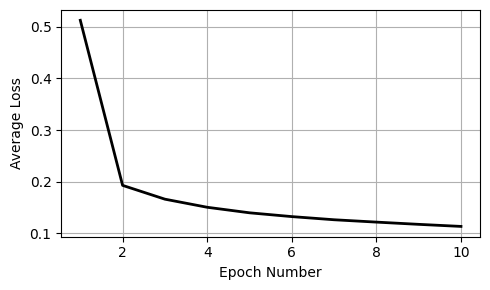

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,len(loss_trace)+1), loss_trace, lw=2, c='k')
plt.grid()
plt.xlabel('Epoch Number')
plt.ylabel('Average Loss')
plt.tight_layout()
plt.show()

## Saving and loading trained models

Obviously if we have a model we've spent all this time training and it looks good, we want to save it so we can use it again later.  Pytorch has built-in saving and loading methods for that.

In [23]:
# Save the model.  Pytorch's save uses python pickling by default, so I like to name the model ending with `.torch.pkl`
saved_model_path = 'vae_2mTemp.torch.pkl'
torch.save(model.state_dict(), saved_model_path)

In [24]:
# We can then load the model back in again with this.  Not going to do it here, but
# these lines, when uncommented would do that.

# First, need to make an untrained instance of our model
#reloaded_model = VAE(latent_size=256)
# Load the model state dictionary from the file
#reloaded_model.load_state_dict(torch.load(saved_model_path, weights_only=True))

# If using for inference, can switch to eval mode here
# You could also pick up training again or doing fine-tuning, in which case you'd
# pass the model into a new training loop
#reloaded_model.eval()

## See how our trained model does

Because our pytorch model expects the input data in a certain format, we write a wrapper function to handle predictions.  It's also easier to use our pytorch Dataset/DataLoader objects to handle the input data, since we set those up so they do things like add a batch dimension and do the normalization of the data for us.


In [25]:
def predict(model, data_loader):
    # Set the model to evaluation mode
    model.eval()
    # Disable gradient calculation
    with torch.no_grad():
        for batch in data_loader:
            x = batch  # Get the images from the batch
            recon_batch, mu, logvar = model(x)  # Forward pass
            return recon_batch, mu, logvar
            
     

In [26]:
# Get some example fields as inputs.  Wrap these with a dataloader so pytorch can understand,
# and normalization happens
test_fields = era5_training[0:4]
test_dataset = XarrayTrainingDataset(test_fields, transform=zscore_normalize_data, transform_params=transform_params)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

# Get the predictions
reconstructed_norm_raw, mu, logvar = predict(model, test_dataloader)
reconstructed_norm_raw.shape

torch.Size([4, 1, 240, 120])

In [27]:
# Put these pytorch arrays into xarray DataArrays
reconstructed_norm = xr.DataArray(reconstructed_norm_raw.numpy(), dims=test_fields.dims, coords=test_fields.coords)
# IMPORTANT: Undo the normalization!
reconstructed = (reconstructed_norm * transform_params['norm_std']) + transform_params['norm_mean']
reconstructed

<xarray.DataArray (time: 4, channel: 1, longitude: 240, latitude: 120)> Size: 461kB
array([[[[248.1659 , 248.97327, 246.8953 , ..., 257.26913, 250.79678,
          258.53793],
         [247.85724, 247.96138, 248.93726, ..., 252.06735, 251.55971,
          254.4796 ],
         [247.51706, 247.71063, 248.60162, ..., 253.29614, 252.10464,
          251.76474],
         ...,
         [248.51335, 248.0312 , 248.7455 , ..., 251.72021, 250.90036,
          249.05746],
         [247.06424, 248.1419 , 248.61125, ..., 253.19417, 252.31775,
          252.20482],
         [246.49805, 247.28543, 247.51549, ..., 253.87045, 249.40213,
          254.508  ]]],


       [[[248.46843, 249.41757, 247.18906, ..., 256.79468, 250.08983,
          258.41522],
         [248.18138, 248.37587, 249.5185 , ..., 251.37086, 251.11493,
          254.50037],
         [247.58948, 248.07199, 248.84259, ..., 252.42123, 251.35295,
...
          248.72177],
         [247.94409, 250.05353, 249.20142, ..., 251.99878, 251.92378,
          251.6974 ],
         [246.87878, 247.75943, 248.1124 , ..., 253.34161, 248.81401,
          254.29657]]],


       [[[248.38107, 249.19006, 247.36116, ..., 257.0681 , 250.45004,
          258.45956],
         [248.0987 , 247.96265, 249.15564, ..., 252.05684, 251.0782 ,
          254.46756],
         [247.96152, 247.80382, 249.30981, ..., 253.25165, 251.36795,
          251.80904],
         ...,
         [249.10777, 248.72589, 250.10518, ..., 251.49599, 250.57841,
          248.9086 ],
         [247.67378, 249.53206, 249.21921, ..., 252.48267, 251.8425 ,
          252.04536],
         [246.80235, 247.56319, 248.0465 , ..., 253.85974, 249.31432,
          254.51445]]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 960B -90.0 -88.5 -87.0 ... 85.5 87.0 88.5
  * longitude  (longitude) float64 2kB 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * time       (time) datetime64[ns] 32B 1990-01-01 ... 1990-01-01T18:00:00
Dimensions without coordinates: channel

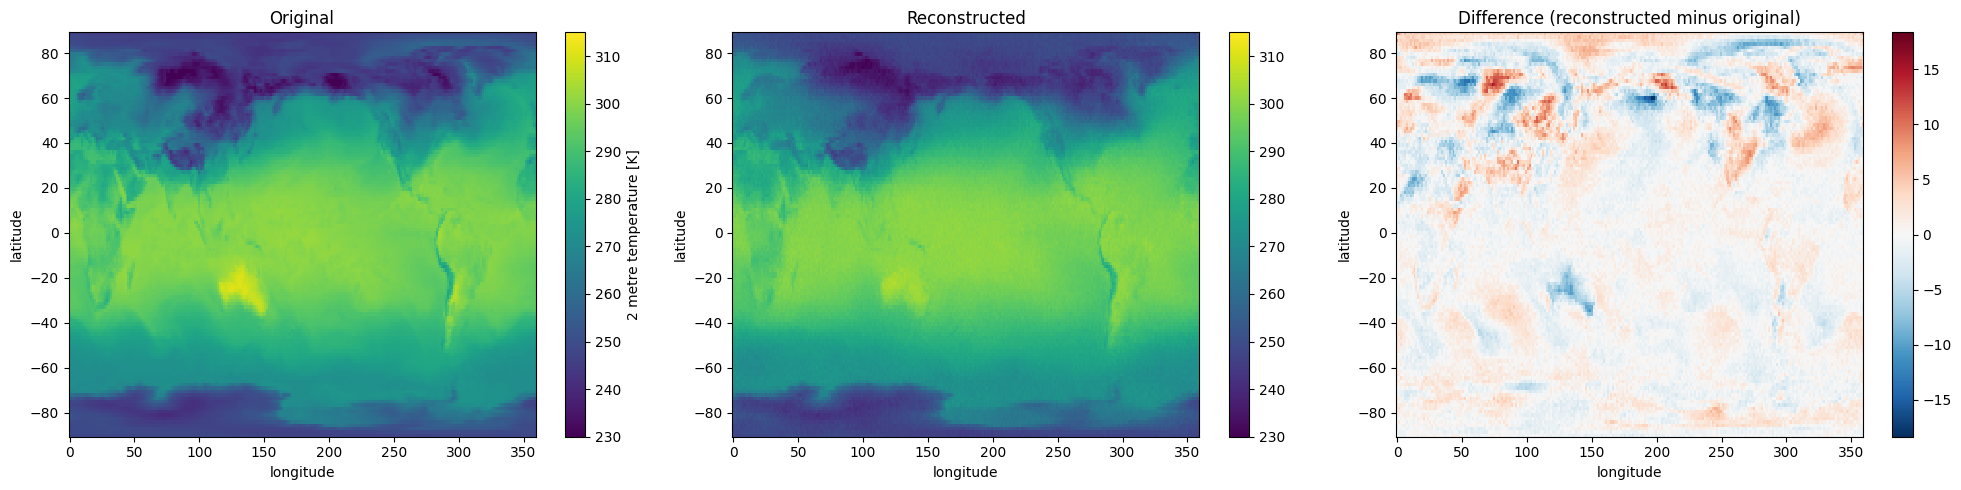

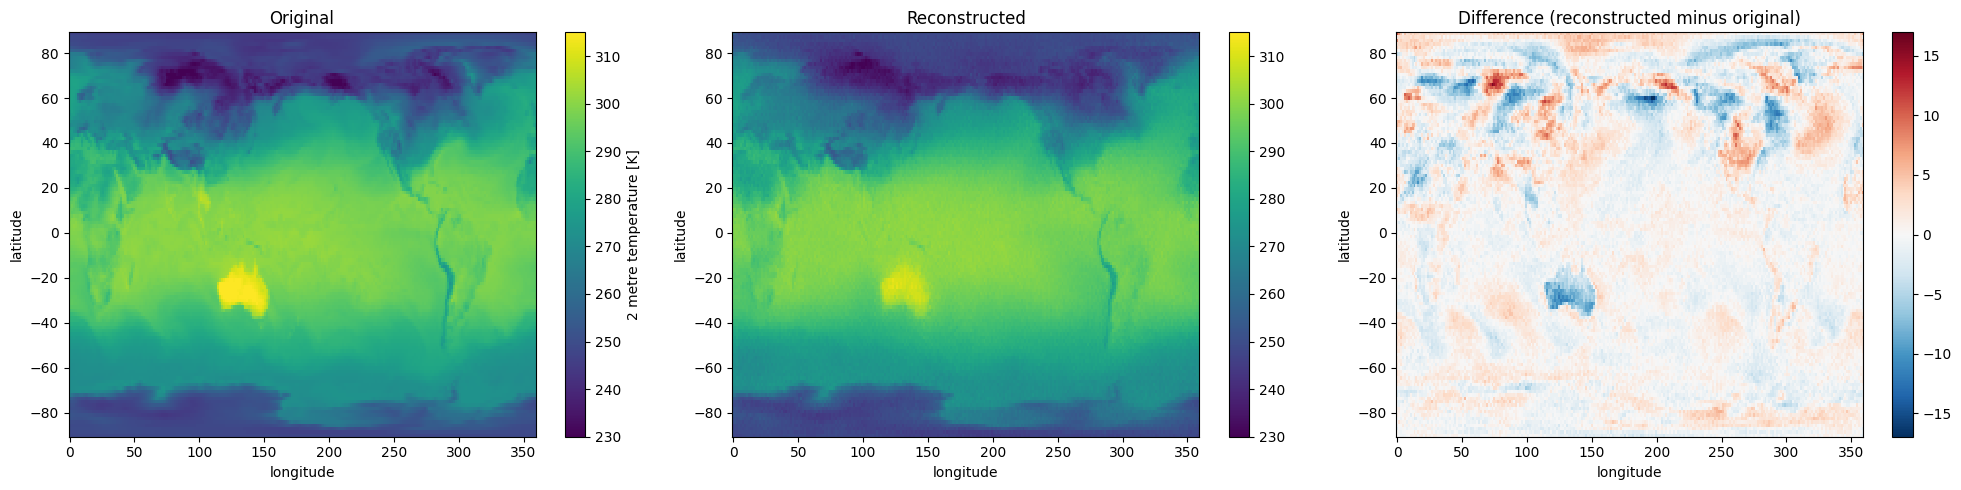

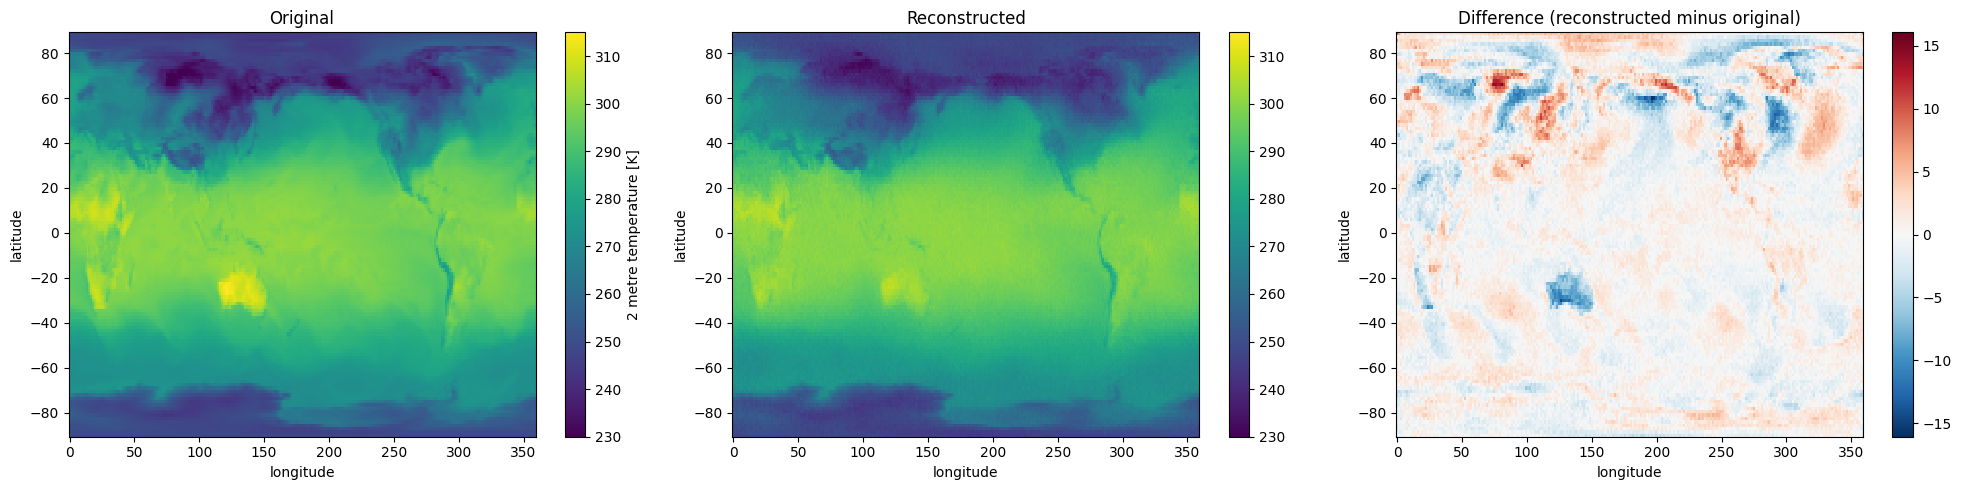

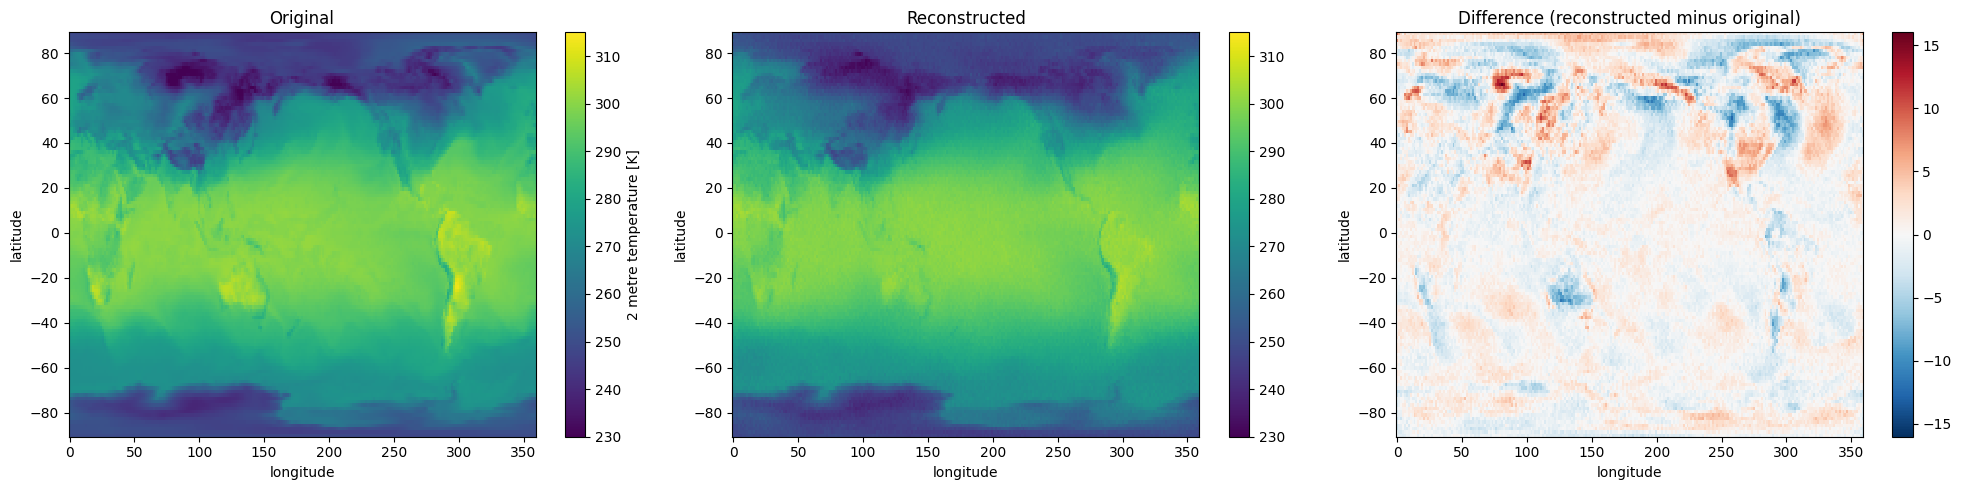

In [28]:
# Compare our generated images to the originals
import matplotlib.pyplot as plt
for n in range(4):
    # We have to transpose all these so they are lat x lon to plot correctly
    # Get the original 2m temperature image
    original_image = test_fields.isel(time=n,channel=0).T
    # Get our model reconstruction of an image
    reconstructed_image = reconstructed.isel(time=n, channel=0).T
    # Also get the difference
    difference = reconstructed_image - original_image

    # Make a map
    plt.figure(figsize=(20,5))
    ax = plt.subplot(1,3,1)
    original_image.plot.imshow(ax=ax, vmin=230, vmax=315, extend='neither')
    ax.set_title('Original')

    ax2 = plt.subplot(1,3,2)
    reconstructed_image.plot.imshow(ax=ax2, vmin=230, vmax=315, extend='neither')
    ax2.set_title('Reconstructed')

    ax3 = plt.subplot(1,3,3)
    difference.plot.imshow(ax=ax3)
    ax3.set_title('Difference (reconstructed minus original)')
    
    plt.tight_layout()
    plt.show()
    

## Use the model as a generator

This VAE can also be used as a generative model by only running the _decoder_ part of the pipeline.  We should be able to generate a random, 2m temperature field by supplying it with a set of random numbers of size `latent_size` (here, 256) drawn from a standard normal distribution.

In [52]:
# Draw 256 values from the standard normal distribution
random_sample = torch.randn(256)
random_sample

tensor([ 0.1321,  0.3335, -0.2950,  1.2896, -0.4999, -0.7621,  0.5678,  1.8213,
         0.4112,  0.3195,  0.6997,  1.4364, -0.2003,  0.5066, -2.3973, -1.5290,
         2.0238, -0.6610,  0.1032, -1.2843,  0.3484, -0.7400,  2.1746, -0.0444,
        -0.0284,  1.4562, -0.8857,  0.2214,  1.1465, -0.8433,  0.5449,  0.6927,
         0.3033, -0.2492, -0.2334,  2.3075,  1.1452, -1.0711,  1.6822, -1.4843,
        -0.9469, -0.3423, -0.5956,  0.2035, -0.3158, -0.6581, -2.0982,  1.3041,
        -1.0004,  0.4390, -0.1628,  0.5595,  1.1689,  1.0330,  0.5463,  0.7311,
        -0.0498, -0.0042, -0.5870, -1.5092, -1.9360, -1.7409, -1.7807, -0.2944,
        -1.1852,  1.3014, -1.4522, -1.9704, -1.3446,  1.0735,  1.0825, -0.8517,
         1.1688,  1.3384,  0.6788, -2.0312,  0.2683, -0.9088,  0.1681,  0.6616,
         0.8484, -0.5941,  1.9047, -1.1960,  0.2474,  1.2519, -0.8213, -0.6197,
        -1.3990, -0.0197,  1.6097, -0.9863,  1.8651,  0.2350, -0.1659, -0.6919,
        -0.9211,  0.0682,  0.8093,  0.81

In [53]:
# Run that through our model's decoder sequence
# And don't try to capture the gradient here
with torch.no_grad():
    decoded_field = model.decode(random_sample)
# We get an array of batch size 1, time 1, 240 lon by 120 lat
decoded_field.shape

torch.Size([1, 1, 240, 120])

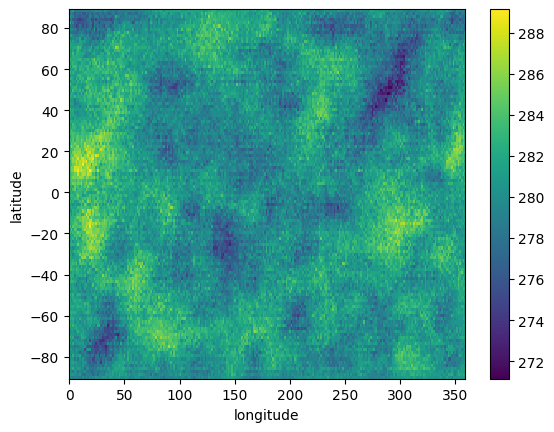

In [54]:
# Wrap this up using xarray and our coordinates and take a look
decoded_array = xr.DataArray(decoded_field[0,0].numpy(), dims=('longitude','latitude'), coords={'longitude':era5_training.coords['longitude'],'latitude':era5_training.coords['latitude']})
# IMPORTANT: undo the normalization!
decoded_array = (decoded_array * transform_params['norm_std']) + transform_params['norm_mean']
decoded_array.T.plot.imshow()

## Concluding thoughts

^^^ Notice that the field we generated doesn't really look like a global map of temperatures, at least not nearly as nice as the ones generated from the encoded 2m temperatuer fields.  There is definitely some coherent structure there, but it doesn't have the expected geographical pattern, and there's a lot of noise.  Furthermore, the values are noisy and the range of final temperature magnitudes is much smaller than what we expect.  

This is suggesting that the latent space components aren't really "standardized" yet...it's likely when we are encoding all our 2m temperature fields that some latent space components have means that are not at zero, or standard deviations that are much larger than one. 

There's a lot of things you could do to try and improve the model to meet this expectation.  Some thoughts would be:

- Do a more thorough normalization than just taking the _global_ mean and standard deviation.  That still means the model is learning very basic climatological patterns that are persistant across all training samples (e.g., the poles are always colder than the equator).  To recreate that structure, it could be that some components of the latent space have to be biased in a certain way, so drawing purely random values wouldn't recreate that structure.  We could instead normalize by taking the mean and standard deviation _of every grid point separately_ and normalizing them in that way.
- Even that above normalization still leaves in things like the diurnal cycle and seasonal cycles here that are persistant and could create that biased structure in the latent space.  We could add parameters to the model to identify what time of day and day of year we were at.  Or, as some of the modern AI weather models do, add another predictor field tha
- You could add a term to the loss function that penalizes the model for creating too much bias in the latent space.  Measuring the Kullback-Leibler Divergence of each latent space component from a standard normal distribution is one way to estimate that.  I included some commented-out code in the loss function for how that might be done.